In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner
from obp.utils import sample_action_fast

In [3]:
# setting
beta=5.0
n_users=1000
n_actions=20
dim_context=10

In [4]:
dataset = SyntheticBanditDataset(
    n_actions=n_actions,
    dim_context=dim_context,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    beta=beta
)
# generate synthetic data
data = dataset.obtain_batch_bandit_feedback(n_rounds=n_users)

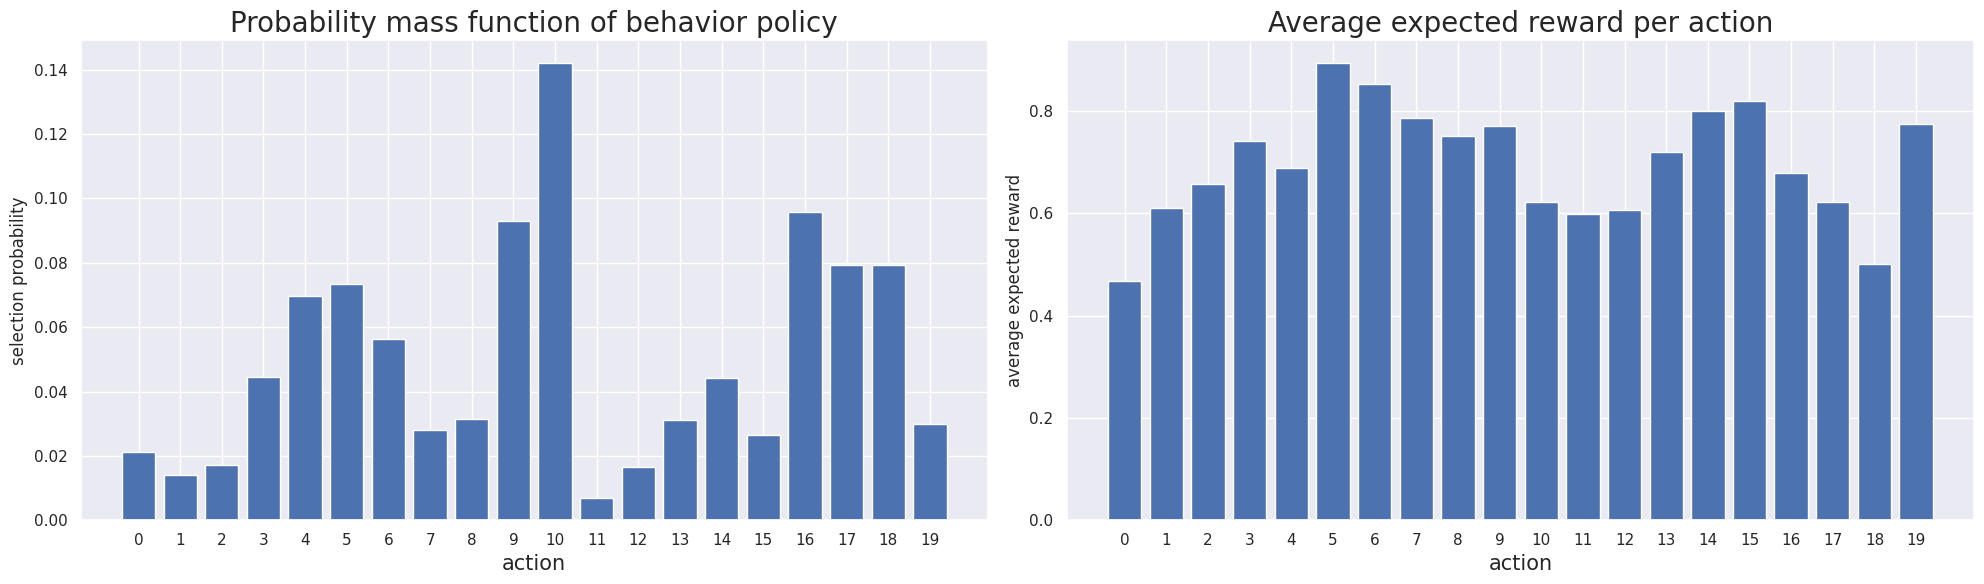

In [8]:
plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
plt.title('Probability mass function of behavior policy', fontsize=20)
plt.bar(x=np.arange(n_actions), height=data["pi_b"][:,:,0].mean(0))
plt.xlabel('action', fontsize=15)
plt.ylabel('selection probability')
plt.xticks(np.arange(n_actions))

plt.subplot(1, 2, 2)
plt.title('Average expected reward per action', fontsize=20)
plt.bar(x=np.arange(n_actions), height=data["expected_reward"].mean(0))
plt.xlabel('action', fontsize=15)
plt.ylabel('average expected reward')
plt.xticks(np.arange(n_actions))

plt.tight_layout()
plt.show()


In [9]:
result_df_list = []

for estimator_name in ["Naive", "IPS"]:
    
    # aggregate selected action by behavior policy 
    result_df = DataFrame()
    result_df["user"] = np.arange(n_users)
    result_df["action"] = data["action"]
    result_df["policy_name"] = "behavior_policy"
    result_df["estimator"] = estimator_name
    result_df_list.append(result_df)

    policies = {"LogisticRegression": LR(), "GradientBoost": GBC(learning_rate=0.01, n_estimators=10)}
    for policy_name, policy in policies.items():

        model = IPWLearner(
            n_actions=n_actions,
            base_classifier=policy
        )
        
        pscore = data["pscore"] if estimator_name == "IPS" else None
        
        # Off-Policy Learning
        model.fit(
            context=data["context"],
            action=data["action"],
            reward=data["reward"],
            pscore=pscore
        )
        # compute action distribution of the evaluation policy
        pi_e = model.predict_score(context=data["context"])[:,:,0]

        result_df = DataFrame()
        result_df["user"] = np.arange(n_users)
        result_df["action"] = sample_action_fast(pi_e, random_state=12345)
        result_df["policy_name"] = policy_name
        result_df["estimator"] = estimator_name

        result_df_list.append(result_df)

result_df = pd.concat(result_df_list, axis=0).reset_index(drop=True)

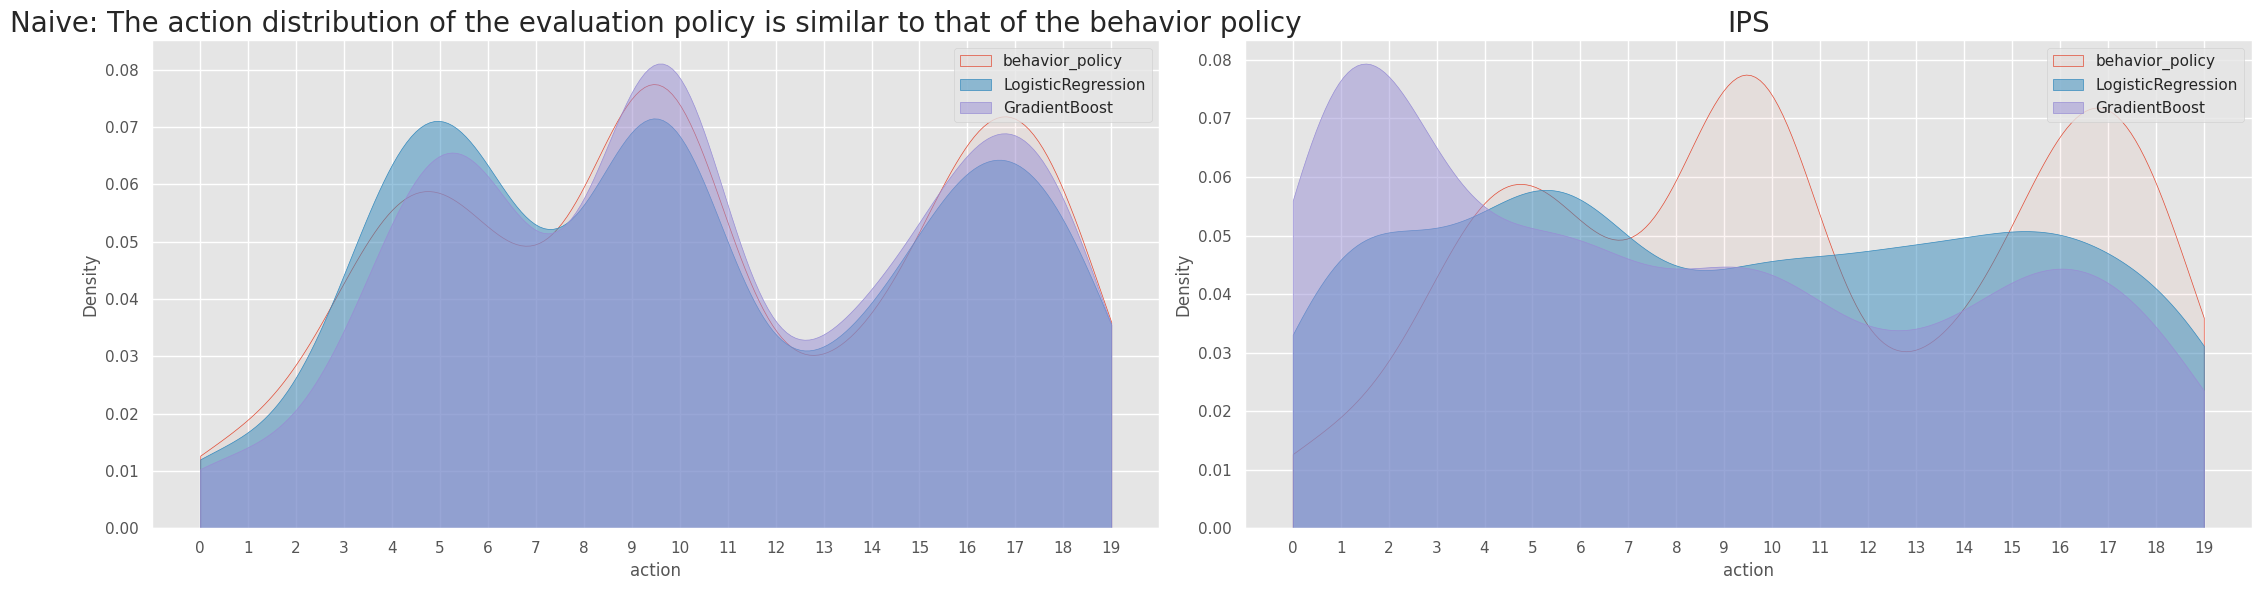

In [14]:
control = {"alpha": 0.05}
experiment = {"alpha": 0.5}
settings = {"behavior_policy": control, "LogisticRegression": experiment, "GradientBoost": experiment}
estimators = ["Naive", "IPS"]
titles = ["Naive: The action distribution of the evaluation policy is similar to that of the behavior policy", "IPS"]

plt.style.use("ggplot")
fig, axes = plt.subplots(1, 2, figsize=(22, 6))

for ax, estimator, title in zip(axes, estimators, titles):
    for policy, setting in settings.items():
        indicator = (result_df["estimator"] == estimator) & (result_df["policy_name"] == policy)

        sns.kdeplot(
            data=result_df[indicator], 
            x="action",
            shade=True,
            clip=[0,19],
            alpha=setting["alpha"],
            label=policy,
            ax=ax,
        )
        
        ax.set_title(title, fontsize=20)
        ax.set_xticks(np.arange(n_actions))
        ax.set_xlim([-1, 20])
        ax.legend()


plt.tight_layout()
plt.show()